<a href="https://www.youtube.com/watch?v=mUYXhzVrDF8&list=PLxqBkZuBynVS8mDTc8ZGermXiS-32pR2y&index=38&ab_channel=Rohan-Paul-AI"><h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Link YouTube Video - Feature Engineering for Bitcoin Time Series | Prediction with XGBoost </b></h1></a>

[![IMAGE ALT TEXT](https://imgur.com/f69J9EO.png)](https://www.youtube.com/watch?v=mUYXhzVrDF8&list=PLxqBkZuBynVS8mDTc8ZGermXiS-32pR2y&index=38&ab_channel=Rohan-Paul-AI)


-------------------------

I will work work with a Time Series Data of Bitcoing prices taken from this recent Kaggle Competion and apply some of the most typical Feature Engineering to make it ready for any tabular Machine Learning Algorithm. And then I will apply XGBoost to come up with a Prediction of Bicoin Prices.

### Contents

[Preprocessing](#Preprocessing)  

[Feature engineering](#Feature-engineering)  

[XGBOOST Data Preparation](#XGBOOST-Data-Preparation)

[XGBOOST Training](#XGBOOST-Training)

[XGBOOST Inference on Test set](#XGBOOST-Inference-on-Test-set)

--------------

In [100]:
import pandas as pd
import numpy as np
import os 
import time

import matplotlib.pyplot as plt

from datetime import datetime

import plotly.graph_objects as go
import plotly.express as px

from preprocess import *
from train import *

In [101]:
ROOT_DIR = '../input/'

# ROOT_DIR = '../input/g-research-crypto-forecasting/' # Kaggle Kernel

In [104]:
start = time.time()

main_full_df = pd.read_csv(os.path.join(ROOT_DIR, 'train.csv'))
# main_full_df = pd.read_csv(os.path.join(ROOT_DIR, 'train.csv'), nrows=10000)

end = time.time()
print(end - start) # just ouf curiosity, see how long it takes to read such a large csv file

12.830771684646606


In [105]:
main_full_df.shape

(24236806, 10)

## There are approximately 24 million observations in our time series.

In [106]:
main_full_df.head(2)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.58,2399.50,2357.14,2374.59,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.53,8.53,8.53,8.53,78.380000,8.530000,-0.014399


In [108]:
get_dataframe_memory_usage(main_full_df)

Total memory consumed by the DataFrame: 1849.12 MB


## Reduce the memory of this large dataframe

In [109]:
main_full_df = reduce_memory_usage(main_full_df)

In [110]:
get_dataframe_memory_usage(main_full_df)

Total memory consumed by the DataFrame: 716.53 MB


**Data features**  

- **timestamp** - Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
- **Asset_ID** - uniquely identifies the traded coin
- **Count** - number of trades executed within the respective minute
- **Open, High, Low, Close** - the usual price details for a given unit of time. 
- **Volume** - amount of units of this coin traded in the particular minute
- **VWAP** - The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
- **Target** - Residual log-returns for the asset over a 15 minute horizon <- we know this from the competition's official description.

In [114]:
start = main_full_df.iloc[0].timestamp.astype('datetime64[s]')
# .iloc[0] - Selects the first row in the DataFrame using integer-location-based indexing (iloc) with the index 0.
# .astype('datetime64[s]'): This part of the code is converting the value in the 'timestamp' column to 'datetime64[s]' format that represents a datetime with a time resolution of seconds.

end = main_full_df.iloc[-1].timestamp.astype('datetime64[s]')

print(f'Data from {start} until {end}')

Data from 2018-01-01T00:01:00 until 2021-09-21T00:00:00


We have approximately 3 years worth of data. This informs the type of time windows we can look at.  

For example, if we zoom out at an yearly resolution, we can only compare 2018, 2019 and 2020 (2021 is incomplete).

# Basic trading data visualization

Get a subset of our data (the last 60 entries for example) and restrict the analysis to one asset (which makes it a univariate analysis). 

In [117]:
btc_mini_df_60_rows = main_full_df[main_full_df.Asset_ID == 1].iloc[-60:]

Let's transform the timestamp into the index of our dataframe. This will facilitate some operations down the road.

In [118]:
btc_mini_df_60_rows = btc_mini_df_60_rows.set_index("timestamp")

use the **candlestick** function from the **graph_objects package** of plotly to visualize trading data as the common candlestick plot.

## The `go.Candlestick` trace in Plotly expects the input data to be of type float64 or float32.

Therefore, if your DataFrame columns are of type float16, you may need to convert them to a supported data type before passing them to the go.Candlestick trace.

Hence, before check the Dtype of the columns of my btc_shorter_df_for_training

And if some of them are of float16, I need a solution to run `go.Candlestick` while keeping the type float16 

### Create some new variables for `go.Candlestick` so that I can keep the type float16

In [119]:
import plotly.graph_objects as go

# Convert float16 columns to float32 for plotting
open_data = btc_mini_df_60_rows['Open'].astype('float32')
high_data = btc_mini_df_60_rows['High'].astype('float32')
low_data = btc_mini_df_60_rows['Low'].astype('float32')
close_data = btc_mini_df_60_rows['Close'].astype('float32')

fig = go.Figure(data=[go.Candlestick(x=btc_mini_df_60_rows.index, 
                                     open=open_data, 
                                     high=high_data, 
                                     low=low_data, 
                                     close=close_data)])
fig.show()


Although candlestick plots are visually appealing, we will delve further into analyzing the trends, cycles, and seasonal patterns of the dataset. Currently, candlestick plots are only serving as a preliminary tool to help us obtain a basic view of the data.

# Preprocessing

Detecting features for which we have missing values is easy to do. We just look for null values per column.   

In [120]:
btc_df = main_full_df[main_full_df.Asset_ID == 1].set_index('timestamp')

btc_df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
Index: 1956282 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Asset_ID  1956282 non-null  int8   
 1   Count     1956282 non-null  float32
 2   Open      1956282 non-null  float16
 3   High      1956282 non-null  float16
 4   Low       1956282 non-null  float16
 5   Close     1956282 non-null  float16
 6   Volume    1956282 non-null  float32
 7   VWAP      1956282 non-null  float64
 8   Target    1955978 non-null  float16
dtypes: float16(5), float32(2), float64(1), int8(1)
memory usage: 57.8 MB


Or I can check for existenc of the null valued directly

## Histograms and density plots  

Some linear time series forecasting methods assume a well-behaved distribution of observations (like a normal distribution).  

Before doing statistical tests to formally assess the assumption of normality, we can easily visualize our data as a histogram.

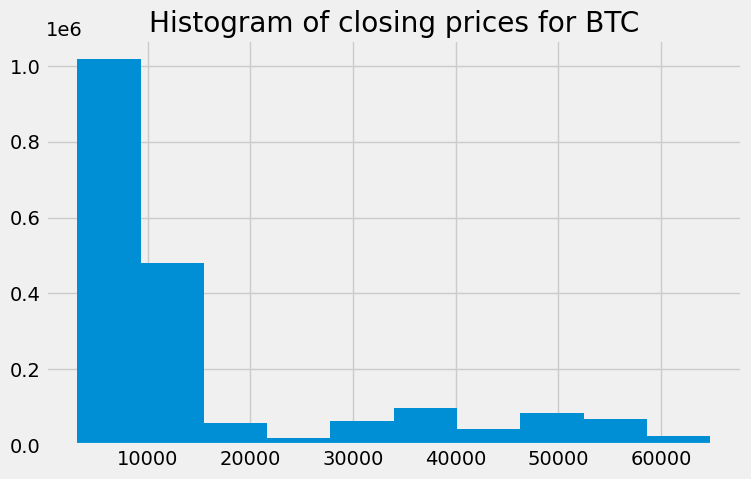

In [121]:
btc_df.Close.hist(figsize=(8,5))
plt.title('Histogram of closing prices for BTC')
plt.show()

## KDE Density Plot

In [122]:
btc_df.Close.plot(kind='kde')
plt.title('Density plot of closing prices for BTC')
plt.show()

In [123]:
btc_df.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64

Only a very small portion of the data is missing. We can drop those rows, impute the values etc. For now I am just going to leave it as it is, and deal with later.

## The more difficult to find missing data is when we don't have any information at all for a particular minute. Which means that **whole rows may be missing** from our dataset.  

We should have one row per minute per asset. Since we extracted the data for a single asset, we expect consecutive rows to have a difference of 60 seconds between their index values.  

So, I want check the **time lag between consecutive entries** in our dataset.

In [124]:
check_for_missing_timestamp(btc_df)

timestamp
60     1956136
120         78
180         12
240         11
420          9
Name: count, dtype: int64

From above, we can see that we have 78 instances where two consecutive entries are 120 seconds apart, instead of 60 sec, 12 instances which are apart by 180 seconds and so on.

Now, given, this small gaps in data, the simple imputation strategy that we can apply here is that - fill in the missing data with the value from the most recent available minute.  

In [125]:
btc_df = impute_missing_data(btc_df)
btc_df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13832.0,14016.0,13664.0,13848.0,31.550062,13827.062093,-0.014641
1514764920,1,235.0,13832.0,14056.0,13680.0,13832.0,31.046432,13840.362591,-0.015038
1514764980,1,528.0,13824.0,14000.0,13600.0,13800.0,55.061821,13806.068014,-0.010307
1514765040,1,435.0,13800.0,14000.0,13576.0,13768.0,38.780529,13783.598101,-0.009003
1514765100,1,742.0,13768.0,13952.0,13552.0,13728.0,108.501640,13735.586842,-0.008080


## Check the output to see no missing timestamp

In [126]:
check_for_missing_timestamp(btc_df)

timestamp
60    1956959
Name: count, dtype: int64

We don't need the index as a timestamp anymore. So lets just have it as a date.

In [127]:
def set_datetime_index(df: pd.DataFrame, index_name: str = 'datetime') -> pd.DataFrame:
    """
    This function sets the DataFrame index to the specified datetime index.

    :param df: Input DataFrame with the timestamp column
    :param index_name: Name of the datetime index column (default: 'datetime')
    :return: DataFrame with the new datetime index
    """

    # Step 3: Inside the function, perform the operations on the input DataFrame
    df[index_name] = df.apply(lambda r: np.float64(r.name).astype('datetime64[s]'), axis=1)
    df.set_index(index_name, inplace=True)

    # Step 4: Return the modified DataFrame
    return df

""" In this lambda function, `r.name` refers to the index of the row r being processed. `np.float64(r.name)` converts the index value to a `float64` data type.

This is because,  when working with time-series data or data that involves calculations with decimal points, it may be necessary to use a float data type for the index to ensure precision in the calculations. In such cases, float64 data type may be preferred for its high precision and wider range of representable values compared to other floating-point data types.

Then, the `astype()` method is called on the float64 value, with the argument 'datetime64[s]', which converts the float64 value to a datetime object with second-level precision.

Finally, the lambda function returns the datetime object, which is assigned to the 'datetime' column of the DataFrame. """

" In this lambda function, `r.name` refers to the index of the row r being processed. The index values are assumed to be of float64 data type, so `np.float64(r.name)` converts the index value to a `float64` data type.\n\nThen, the `astype()` method is called on the float64 value, with the argument 'datetime64[s]', which converts the float64 value to a datetime object with second-level precision.\n\nFinally, the lambda function returns the datetime object, which is assigned to the 'datetime' column of the DataFrame. "

In [128]:
btc_df = set_datetime_index(btc_df)
btc_df.head(3)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
datetime,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13832.0,14016.0,13664.0,13848.0,31.550062,13827.062093,-0.014641
2018-01-01 00:02:00,1,235.0,13832.0,14056.0,13680.0,13832.0,31.046432,13840.362591,-0.015038
2018-01-01 00:03:00,1,528.0,13824.0,14000.0,13600.0,13800.0,55.061821,13806.068014,-0.010307


# Feature engineering


A. Transform the timestamp into day, hour, min, creating 3 new features

B. Build Lag Features of - Price(t-2), Price(t-1), Price(t), Price(t+1)

C. Create Window features of Mean, Max, Min using the expanding() method in Pandas

## Transform the timestamp into day, hour, min, creating 3 new features

 (1st Feature engineering for this exercise)

In [129]:
24*60*3*365 # Number of minutes in 3 Years

1576800

In [130]:
24*60*5

7200

In [131]:
# btc_shorter_df_for_training = btc_df[-7200:].copy(deep=True)  # 5 Days
btc_shorter_df_for_training = btc_df[-1576800:].copy(deep=True)  # For 3 Years


In [132]:
btc_shorter_df_for_training.head(2)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
datetime,,,,,,,,,
2021-09-16 00:00:00,1,2466.0,48128.0,48192.0,48096.0,48096.0,100.182816,48132.845372,0.001079
2021-09-16 00:01:00,1,1757.0,48096.0,48160.0,48064.0,48128.0,64.948784,48112.135086,0.001212


In [133]:
btc_shorter_df_for_training['time'] = btc_shorter_df_for_training.apply(lambda r:r.name, axis=1) # I need to move timestamp back into a column

# and parse it into year, month, day and hour
btc_shorter_df_for_training['year'] = [btc_shorter_df_for_training.iloc[i].time.year for i in range(len(btc_shorter_df_for_training))]  
btc_shorter_df_for_training['month'] = [btc_shorter_df_for_training.iloc[i].time.month for i in range(len(btc_shorter_df_for_training))]
btc_shorter_df_for_training['day'] = [btc_shorter_df_for_training.iloc[i].time.day for i in range(len(btc_shorter_df_for_training))]
btc_shorter_df_for_training['hour'] = [btc_shorter_df_for_training.iloc[i].time.hour for i in range(len(btc_shorter_df_for_training))]

In [134]:
btc_shorter_df_for_training.head(3)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,year,month,day,hour
datetime,,,,,,,,,,,,,,
2021-09-16 00:00:00,1,2466.0,48128.0,48192.0,48096.0,48096.0,100.182816,48132.845372,0.001079,2021-09-16 00:00:00,2021,9,16,0
2021-09-16 00:01:00,1,1757.0,48096.0,48160.0,48064.0,48128.0,64.948784,48112.135086,0.001212,2021-09-16 00:01:00,2021,9,16,0
2021-09-16 00:02:00,1,2331.0,48128.0,48224.0,48064.0,48192.0,101.655800,48125.096256,0.001464,2021-09-16 00:02:00,2021,9,16,0


## Lag features (2nd Feature engineering for this exercise)

The idea is to predict the value at the current timestamp based on the value from the previous timestamp(s).   

- the number of previous time steps we use in our prediction is called the **width of the time window** or **the lag**
- if we predict only one future time step we are doing **one-step forecast**. We can also perform **multi-step forecast** and predict multiple next steps at once 
- this method is also called **sliding window**, with a window width of 1 in our case below.

Initial dataset:  

| time | value |  
| --- | ---|   
| t1 | v1  
| t2 | v2  
| t3 | v3

becomes:    

| x | y | 
| --- | --- |     
| ? | v1      
| v1 | v2  
| v2 | v3  

The actual value for timestamp is gone from our data. We don't care about it, as long as we preserve the order. We only care about the actual value at the previous point in time.

We use pandas' dataframe.shift() function, which shifts values vertically or horizontally, fills in with NaN values and leaves the index as it is.

In [137]:
tmp = btc_shorter_df_for_training['Close'] # extract only the Close price

lag_df = pd.concat([tmp.shift(1, axis = 0), tmp], axis=1) # downward shift by 1 step 


# the original price series becomes the time t+1 value, 
# while the downward shifted series is time t
lag_df.columns = ['Close(t)', 'Close(t+1)'] 

lag_df.head()

,Close(t),Close(t+1)
datetime,,
2021-09-16 00:00:00,NaN,48096.0
2021-09-16 00:01:00,48096.0,48128.0
2021-09-16 00:02:00,48128.0,48192.0
2021-09-16 00:03:00,48192.0,48160.0
2021-09-16 00:04:00,48160.0,48096.0


tmp.shift(1, axis=0) is used to create a new DataFrame that is shifted by one time step (or one row) along the time axis (axis=0). This operation effectively moves each row's data one step forward, leaving a NaN value in the first row of the DataFrame. This new DataFrame has the same column names as the original tmp DataFrame.

pd.concat([tmp.shift(1, axis=0), tmp], axis=1) concatenates the shifted DataFrame from step 2 and the original tmp DataFrame along the columns axis (axis=1). This operation results in a new DataFrame called lag_df with twice the number of columns as the original tmp DataFrame.

-----------------------------------

### Lag Features (The same transformation as above, but this time we include the 3 previous values, for each future time t+1:)

In [139]:
tmp = btc_shorter_df_for_training['Close']
lag_df = create_lagged_dataframe(tmp, lag_values=[3, 2, 1] )
lag_df.head()


,Close,Close,Close,Close
datetime,,,,
2021-09-16 00:00:00,NaN,NaN,NaN,48096.0
2021-09-16 00:01:00,NaN,NaN,48096.0,48128.0
2021-09-16 00:02:00,NaN,48096.0,48128.0,48192.0
2021-09-16 00:03:00,48096.0,48128.0,48192.0,48160.0
2021-09-16 00:04:00,48128.0,48192.0,48160.0,48096.0


Finally, the lag does not have to be linear: we don't necessarily have to use the previous k values. We can include in the lag window values from the same day last week or the same hour the day before etc. 

## Window features   (3rd Feature engineering for this exercise)

We saw how we can add a window of a certain width as features to be used by our model to forecast the value at future time t+1.  

Besides using the raw values from the time window (i.e. Close(t-1), Close(t), etc), we can also compute *summary statistics* of these values and use them as features for prediction.  

The most common aggregate value is the mean of the lag window (also called **moving average** or **rolling mean**).

| time | value |  
| --- | --- |  
| t1 | v1  
| t2 | v2  
| t3 | v3  
| t4 | v4

**shifted**  

| time | value | 
| --- | --- |  
| t1 | ?  
| t2 | v1  
| t3 | v2  
| t4 | v3

## shifted + applying **rolling mean** (aka moving average ) with a window size of 2  

| time | value | 
| --- | --- |  
| t1 | ? |  
| t2 | ? | 
| t3 | (v1+v2) / 2 | 
| t4 | (v2+v3) / 2 |

Final dataset

| time | mean | Close(t+1) |  
| --- | --- | --- |   
t1&emsp;$\;$|  ?  |  v1  |  
t2&emsp;$\;$|  ?  |  v2  |  
t3&emsp;$\;$|  (v1+v2) / 2  |  v3  |  
t4&emsp;$\;$|  (v2+v3) / 2  |  v4  |  

The moving average can be used as a naive prediction model: predict for next day the average of the last *w* days (where *w* is the width of the moving average window). 

---------------------

### While a moving average can be applied to both stationary and non-stationary time series data, the insights derived from non-stationary data might be less reliable. It is generally preferable to make the time series stationary before applying a moving average to ensure meaningful results.

The reason Moving Average requires stationary time series data is because the technique assumes that the statistical properties of the data are constant over time. If the data is not stationary, then the mean, variance, and covariance of the data will change over time, and this will result in inaccurate trend identification.

 so we'll need some further preprocessing down the road. 

In [140]:
tmp = btc_shorter_df_for_training['Close'] # extract only the Close price

lag_df = tmp.shift(1) # downward shift by 1

window = lag_df.rolling(window=2) # rolling window size of 2
#  creates a rolling window object that contains a fixed-size sliding window of data points, which is centered around a specified point or a moving window that shifts over the data. The window function can be applied to a variety of statistical calculations, including moving averages, rolling standard deviation, and more complex functions.

means = window.mean() # compute the means for the rolling windows

modified_df = pd.concat([means, tmp], axis=1) # concatenate the two series vertically

modified_df.columns = ['mean(t-1,t)', 't+1'] # rename columns for easier reading

modified_df.head()

,"mean(t-1,t)",t+1
datetime,,
2021-09-16 00:00:00,NaN,48096.0
2021-09-16 00:01:00,NaN,48128.0
2021-09-16 00:02:00,48112.0,48192.0
2021-09-16 00:03:00,48160.0,48160.0
2021-09-16 00:04:00,48176.0,48096.0


There are of course many summary statistics we can use besides the average for the previous time window.    

### Also, the window does not have to have a fixed width. It can also be a forever expanding window.  

| time | value |
| --- | --- | 
| t1 | 1 | 
| t2 | 2 | 
| t3 | 3 | 
| t4 | 4 | 
| t4 | 5 |

**expanding** rolling window  

| # |values |
| --- | --- |
| 0 | 1 2 |
| 1 | 1 2 3 |
| 2 | 1 2 3 4 |
| 4 | 1 2 3 4 5 |

final engineered dataset having summay statistics (min, mean and max window values) computed for the **expanding** rolling window

| # | min | mean | max | t+1 |
| --- | --- | --- | --- | --- |
| 0 | 1 | 1 | 1 | 2 |
| 1 | 1 | 1.5 | 2 | 3 |
| 2 | 1 | 2 | 3 | 4 |
| 3 | 1 | 2.5 | 4 | 5 |

---------------------

## Expanding method in Pandas

The series.expanding() method is one of the window methods of pandas and it Provides expanding transformations. It is used to perform cumulative computations on a time series or any other ordered data. The method calculates an expanding window of calculations over a DataFrame or a Series object.

The expanding method can be applied to any aggregation function, such as mean(), sum(), min(), max(), std(), var(), and quantile(), among others. The expanding method calculates the specified aggregation function over an expanding window of data points, starting from the first data point and increasing the size of the window as it moves forward in time.

And it returns a window subclassed for the particular operation.

The parameters for this method are min_periods, center, axis, and method. The default value for the min_periods is 1 and it also takes an integer value. The center parameter takes a boolean value and the default one is False. In the same way, the default value for the axis parameter is 0, and for the method is ‘single’.

In [141]:
window = tmp.expanding()

dataframe = pd.concat([window.min(), window.mean(), window.max(), tmp.shift(-1)], axis=1)

dataframe.columns = ['min', 'mean', 'max', 't+1']

dataframe.head(5)

,min,mean,max,t+1
datetime,,,,
2021-09-16 00:00:00,48096.0,48096.000000,48096.0,48128.0
2021-09-16 00:01:00,48096.0,48112.000000,48128.0,48192.0
2021-09-16 00:02:00,48096.0,48138.666667,48192.0,48160.0
2021-09-16 00:03:00,48096.0,48144.000000,48192.0,48096.0
2021-09-16 00:04:00,48096.0,48134.400000,48192.0,48064.0


In [142]:
combined_btc_shorter_df_for_training = pd.concat([dataframe, btc_shorter_df_for_training ], axis=1)

## Explanation of above 2 cells and the working of expanding() method here

Expanding window: Unlike a rolling window with a fixed size, an expanding window starts with a minimum size (in this case, 1) and increases its size by one for each subsequent data point. So, for the first data point, the window size is 1, for the second data point, the window size is 2, and so on. The expanding window encompasses all previous data points, which results in the window size growing until it covers the entire dataset.

Calculations: For each window size, the min(), mean(), and max() methods calculate the minimum, mean, and maximum values, respectively, within the expanding window. The results will be pandas Series or DataFrames with the same length as the original tmp object.

You concatenate the results of the min, mean, and max calculations, along with the original data shifted by -1 (i.e., moving all values up by one position). The concatenation is performed along the columns

##  why am I moving all values up by one position by the `tmp.shift(-1)`

This is done to align the target variable 't+1' with the current row's features (min, mean, max) for predictive modeling. By shifting the data up, you are essentially trying to predict the next value in the sequence, given the current row's expanding window statistics.

In [143]:
combined_btc_shorter_df_for_training.head()

,min,mean,max,t+1,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,year,month,day,hour
datetime,,,,,,,,,,,,,,,,,,
2021-09-16 00:00:00,48096.0,48096.000000,48096.0,48128.0,1,2466.0,48128.0,48192.0,48096.0,48096.0,100.182816,48132.845372,0.001079,2021-09-16 00:00:00,2021,9,16,0
2021-09-16 00:01:00,48096.0,48112.000000,48128.0,48192.0,1,1757.0,48096.0,48160.0,48064.0,48128.0,64.948784,48112.135086,0.001212,2021-09-16 00:01:00,2021,9,16,0
2021-09-16 00:02:00,48096.0,48138.666667,48192.0,48160.0,1,2331.0,48128.0,48224.0,48064.0,48192.0,101.655800,48125.096256,0.001464,2021-09-16 00:02:00,2021,9,16,0
2021-09-16 00:03:00,48096.0,48144.000000,48192.0,48096.0,1,2231.0,48192.0,48224.0,48128.0,48160.0,53.992481,48174.667732,0.001517,2021-09-16 00:03:00,2021,9,16,0
2021-09-16 00:04:00,48096.0,48134.400000,48192.0,48064.0,1,2241.0,48160.0,48192.0,48064.0,48096.0,65.479225,48122.721662,0.001424,2021-09-16 00:04:00,2021,9,16,0


In [144]:
# have a look at the initial dataset again, to verify that tha dataframe above is correct
tmp.head(3)

datetime
2021-09-16 00:00:00    48096.0
2021-09-16 00:01:00    48128.0
2021-09-16 00:02:00    48192.0
Name: Close, dtype: float16

### In conclusion, those 3 techniques are fundamental and widely used approaches to transform time series into a dataset suitable for the application of supervised machine learning techniques.

---------------------------

# XGBOOST Data Preparation

In [151]:
TARGET_TEST_CUTOFF_DATE = '08-01-2021'


train = combined_btc_shorter_df_for_training.loc[combined_btc_shorter_df_for_training.index < TARGET_TEST_CUTOFF_DATE]

test = combined_btc_shorter_df_for_training.loc[combined_btc_shorter_df_for_training.index >= TARGET_TEST_CUTOFF_DATE]

In [152]:
print(train.shape)
print(test.shape)

(5760, 18)
(1441, 18)


In [153]:
train.head()

,min,mean,max,t+1,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,year,month,day,hour
datetime,,,,,,,,,,,,,,,,,,
2021-09-16 00:00:00,48096.0,48096.000000,48096.0,48128.0,1,2466.0,48128.0,48192.0,48096.0,48096.0,100.182816,48132.845372,0.001079,2021-09-16 00:00:00,2021,9,16,0
2021-09-16 00:01:00,48096.0,48112.000000,48128.0,48192.0,1,1757.0,48096.0,48160.0,48064.0,48128.0,64.948784,48112.135086,0.001212,2021-09-16 00:01:00,2021,9,16,0
2021-09-16 00:02:00,48096.0,48138.666667,48192.0,48160.0,1,2331.0,48128.0,48224.0,48064.0,48192.0,101.655800,48125.096256,0.001464,2021-09-16 00:02:00,2021,9,16,0
2021-09-16 00:03:00,48096.0,48144.000000,48192.0,48096.0,1,2231.0,48192.0,48224.0,48128.0,48160.0,53.992481,48174.667732,0.001517,2021-09-16 00:03:00,2021,9,16,0
2021-09-16 00:04:00,48096.0,48134.400000,48192.0,48064.0,1,2241.0,48160.0,48192.0,48064.0,48096.0,65.479225,48122.721662,0.001424,2021-09-16 00:04:00,2021,9,16,0


In [154]:
test.tail()

,min,mean,max,t+1,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,year,month,day,hour
datetime,,,,,,,,,,,,,,,,,,
2021-09-20 23:56:00,42592.0,47213.721273,48768.0,42848.0,1,1940.0,42976.0,43008.0,42880.0,42912.0,56.850914,42935.489499,NaN,2021-09-20 23:56:00,2021,9,20,23
2021-09-20 23:57:00,42592.0,47213.114754,48768.0,42816.0,1,2026.0,42912.0,42944.0,42848.0,42848.0,80.993324,42879.576084,NaN,2021-09-20 23:57:00,2021,9,20,23
2021-09-20 23:58:00,42592.0,47212.503959,48768.0,43008.0,1,1986.0,42848.0,42880.0,42784.0,42816.0,65.677734,42844.090693,NaN,2021-09-20 23:58:00,2021,9,20,23
2021-09-20 23:59:00,42592.0,47211.920000,48768.0,43008.0,1,4047.0,42848.0,43040.0,42816.0,43008.0,138.335480,42935.761938,NaN,2021-09-20 23:59:00,2021,9,20,23
2021-09-21 00:00:00,42592.0,47211.336203,48768.0,NaN,1,2698.0,43008.0,43040.0,42976.0,43008.0,128.206818,43011.414052,NaN,2021-09-21 00:00:00,2021,9,21,0


In [155]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1441 entries, 2021-09-20 00:00:00 to 2021-09-21 00:00:00
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   min       1441 non-null   float64       
 1   mean      1441 non-null   float64       
 2   max       1441 non-null   float64       
 3   t+1       1440 non-null   float16       
 4   Asset_ID  1441 non-null   int8          
 5   Count     1441 non-null   float32       
 6   Open      1441 non-null   float16       
 7   High      1441 non-null   float16       
 8   Low       1441 non-null   float16       
 9   Close     1441 non-null   float16       
 10  Volume    1441 non-null   float32       
 11  VWAP      1441 non-null   float64       
 12  Target    1425 non-null   float16       
 13  time      1441 non-null   datetime64[ns]
 14  year      1441 non-null   int64         
 15  month     1441 non-null   int64         
 16  day       1441 non-null 

In [156]:
test.isna().sum()

min          0
mean         0
max          0
t+1          1
Asset_ID     0
Count        0
Open         0
High         0
Low          0
Close        0
Volume       0
VWAP         0
Target      16
time         0
year         0
month        0
day          0
hour         0
dtype: int64

In [157]:
xgboost_series_features = combined_btc_shorter_df_for_training.columns.to_list()

In [158]:
xgboost_series_features = ['min',
 'mean',
 'max',
 't+1',
 'Count',
 'Open',
 'High',
 'Low',
 'Volume',
 'VWAP',
 'year',
 'month',
 'day',
 'hour']

xgboost_series_target = 'Close'

In [159]:
X_train = train[xgboost_series_features]
y_train = train[xgboost_series_target]

In [160]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5760 entries, 2021-09-16 00:00:00 to 2021-09-19 23:59:00
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   min       5760 non-null   float64
 1   mean      5760 non-null   float64
 2   max       5760 non-null   float64
 3   t+1       5760 non-null   float16
 4   Asset_ID  5760 non-null   int8   
 5   Count     5760 non-null   float32
 6   Open      5760 non-null   float16
 7   High      5760 non-null   float16
 8   Low       5760 non-null   float16
 9   Volume    5760 non-null   float32
 10  VWAP      5760 non-null   float64
 11  year      5760 non-null   int64  
 12  month     5760 non-null   int64  
 13  day       5760 non-null   int64  
 14  hour      5760 non-null   int64  
dtypes: float16(4), float32(2), float64(4), int64(4), int8(1)
memory usage: 500.6 KB


In [161]:
X_test = test[xgboost_series_features]
y_test = test[xgboost_series_target]

# XGBOOST Training

In [162]:
model = train_xgb_regressor(X_train, y_train, X_test, y_test, use_gpu=True)

[05:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:47381.03648	validation_1-rmse:44163.21261
[100]	validation_0-rmse:17350.67173	validation_1-rmse:14257.88285
[200]	validation_0-rmse:6355.65141	validation_1-rmse:3654.74947
[300]	validation_0-rmse:2328.76892	validation_1-rmse:1248.72885
[334]	validation_0-rmse:1655.39675	validation_1-rmse:1527.00952


# Feature Importance

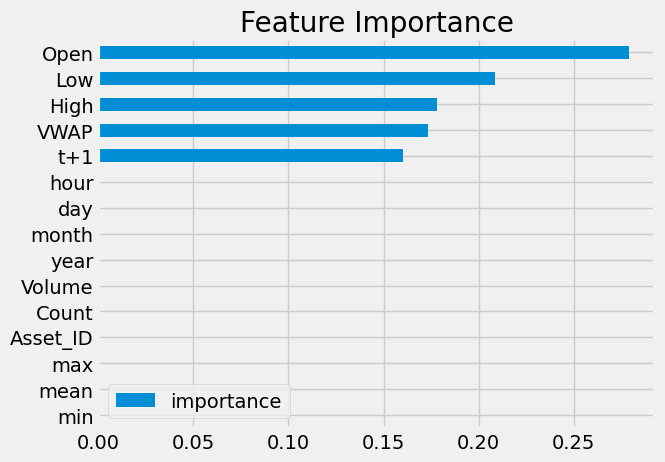

In [163]:
plot_feature_importance(model)

# XGBOOST Inference on Test set

Here I just adding the prediction column to the existing dataframe

In [164]:
test['prediction'] = model.predict(X_test)

df = combined_btc_shorter_df_for_training.merge(test[['prediction']], how='left', left_index=True, right_index=True)

df.tail(2)

C:\Users\PC60\AppData\Local\Temp\ipykernel_10028\3961864123.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,min,mean,max,t+1,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,year,month,day,hour,prediction
datetime,,,,,,,,,,,,,,,,,,,
2021-09-20 23:59:00,42592.0,47211.920000,48768.0,43008.0,1,4047.0,42848.0,43040.0,42816.0,43008.0,138.335480,42935.761938,NaN,2021-09-20 23:59:00,2021,9,20,23,44620.859375
2021-09-21 00:00:00,42592.0,47211.336203,48768.0,NaN,1,2698.0,43008.0,43040.0,42976.0,43008.0,128.206818,43011.414052,NaN,2021-09-21 00:00:00,2021,9,21,0,44787.269531


In [ ]:

ax = df[['Close']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()